<a href="https://colab.research.google.com/github/XimenaLimon/4-methylphthalic-acid-and-its-related-anhydride/blob/main/Tuning_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We install the required libraries.

In [ ]:
%pip install optuna optuna_dashboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [ ]:
#Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import re
import optuna
from optuna_dashboard import run_server
import threading
from google.colab import output


# **Data reading**

1.   To predict the enthalpy of combustion, use the file *Combustion.csv*.
2.   To predict the enthalpy of formation in the gas phase, use the file *Formation_g.csv*.
3. To predict the enthalpy of formation in the crystalline phase, use the file *Formation_cr.csv*.
4. To predict the enthalpy of sublimation, use the file *Sublimation.csv*.


In [ ]:
#Data set
#Use the data set according to the enthalpy to be predicted
#Combustion.csv, Sublimation.csv, Formation_g.csv or Formation_cr.csv
Data=pd.read_csv("/content/drive/MyDrive/4mca/Combustion.csv")
pd.set_option("display.max_rows",None)

In this section, we extract the number of C, H, O, and N atoms from the empirical formula.

In [ ]:
#Function to extract the number of atoms from the compact chemical formula
def parse_formula(formula):
    #Regular expression
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    element_counts = {}
    for (element, count) in matches:
        count = int(count) if count else 1  #If there is no number, 1 is assumed
        element_counts[element] = count
    return element_counts

#Processing of compact chemical formulas
formula_data = Data['Formula'].apply(parse_formula)

#Dataframe with the number of atoms
elements = pd.DataFrame(list(formula_data)).fillna(0)
Data=pd.concat([Data,elements],axis=1)

Here, we use the interquartile range criterion to identify the presence of outliers.

<Axes: ylabel='-∆fH°'>

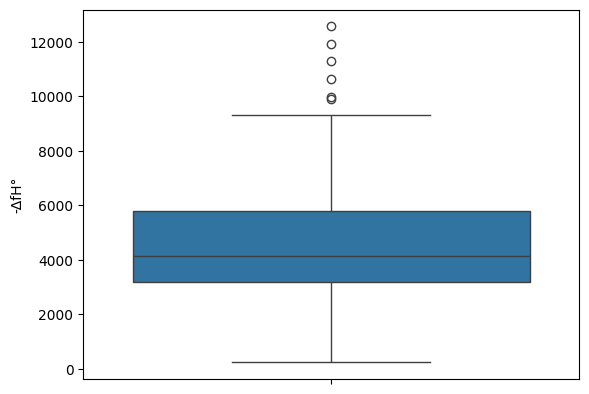

In [ ]:
#Box plot shows outliers with interquartile range criteria
sns.boxplot(Data["-∆fH°"])

Once the outliers are identified, they are removed from the dataset using the Isolation Forest algorithm with 100 estimators.

1. For the combustion enthalpy dataset, use a
contamination rate of 0.11.
2. For the gas-phase formation enthalpy dataset, use a contamination rate of 0.01.
3. For the crystalline-phase formation enthalpy dataset, this step is not applied, as no outliers were identified.
4. For the sublimation enthalpy dataset, use a contamination rate of 0.02.

In [ ]:
#Identification of outliers
#Combustion: contamination --> 0.11
#Formation gas phase: contamination --> 0.01
#Formation cr phase: contamination --> 0, because it has no outliers
#Sublimation: contamination --> 0.02
iso = IsolationForest(contamination=0.11, random_state=42)
Data['outliers'] = iso.fit_predict(Data[['-∆fH°']])
outliers = Data[Data['outliers'] == -1]
Data.drop(outliers.index, inplace=True)

We verify the removal of outliers by visualizing the box-and-whisker plot.

<Axes: ylabel='-∆fH°'>

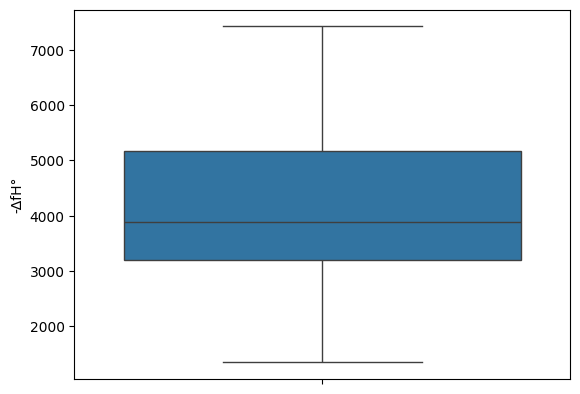

In [ ]:
#Boxplot without outliers removed with isolation forest
sns.boxplot(Data["-∆fH°"])

From the preprocessed dataset, we select the predictor variables and the target variables.

In [ ]:
#Definition of variables
X=Data.iloc[:,3:]
y=Data.iloc[:-1,2]

In [ ]:
#Obtaining variables
pd.set_option("display.max_columns",None)
dummies=pd.get_dummies(X[["group","Correction 1","Correction 2","Correction 3","Correction 4"]], drop_first=True)
X=X.drop(["group","Correction 1","Correction 2","Correction 3","Correction 4"],axis=1)
C=pd.concat([X,dummies],axis=1)

In [ ]:
#Compounds to predict
Compounds=C.iloc[:-1,:]
#predictions=C.loc[73,:]

#The number of data depends on the data set of each enthalpy that you want to predict.

#For Enthalpy of combustion use:
#isomers=C.loc[95:,:]

#For Enthalpy of sublimation use:
#isomers=C.loc[72:,:]

#For Enthalpy of formation in gas phase use:
#isomers=C.loc[82:,:]

#For Enthalpy of formation in crystalline phase use:
#isomers=C.loc[98:,:]

# **Grid search with cross-validation**

In [ ]:
RandomState=[]
BEST_ALPHA=[]
BEST_MODEL=[]
RMSE_TRAIN=[]
RMSE_TEST=[]
MAE_TRAIN=[]
MAE_TEST=[]
R2_TRAIN=[]
R2_TEST=[]

#Iterations for random state in the train_test_split method
for random_state in np.arange(0,1000,1):
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(Compounds,y, test_size=0.3, random_state=random_state)

    #Pipeline. This to add preprocessing steps if necessary.
    pipeline = Pipeline([('ridge', Ridge())])

    #The value of the regularization is varied
    param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

    #Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)

    #Getting the best parameters and fitted model for each iteration of random_state
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #Predict and calculate evaluation metrics
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    #Store results
    RandomState.append(random_state)
    BEST_ALPHA.append(best_params['ridge__alpha'])
    BEST_MODEL.append(best_model)
    RMSE_TRAIN.append(rmse_train)
    RMSE_TEST.append(rmse_test)
    MAE_TRAIN.append(mae_train)
    MAE_TEST.append(mae_test)
    R2_TRAIN.append(r2_train)
    R2_TEST.append(r2_test)


In [ ]:
#Find models with a relative difference of less than 10% between RMSE of the training and test set
RD=[]
for i,j,k in zip(RMSE_TEST,RMSE_TRAIN,RandomState):
  relative_diff=((i-j)/j)*100
  RD.append(relative_diff)
  if relative_diff<10:
    print(i,j,k, abs(relative_diff))

24.007977654517447 22.496088017973555 427 6.720677992262241


In [ ]:
#The results are added in a dataframe
results_df=pd.DataFrame(data=list(zip(RandomState, BEST_ALPHA, RMSE_TRAIN,
                                      RMSE_TEST, MAE_TRAIN, MAE_TEST,
                                      R2_TRAIN, R2_TEST)), columns=["RandomState", "BestAlpha","RMSE_Train",
                                                                    "RMSE_Test", "MAE_Train","MAE_Test",
                                                                    "R2_Train","R2_Test"])

In [ ]:
results_df

,RandomState,BestAlpha,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test
0,0,1.00,18.426979,85.725318,13.060314,45.542916,0.999840,0.996756
1,1,1.00,19.462579,56.262188,13.715790,40.467522,0.999812,0.998769
2,2,1.00,19.105037,54.160844,13.492926,39.015176,0.999838,0.998215
3,3,1.00,20.036324,53.606264,14.727864,35.690023,0.999842,0.997931
4,4,0.10,7.400308,63.492908,5.467777,42.425537,0.999975,0.998017
5,5,1.00,21.370686,39.818732,15.946741,28.777626,0.999739,0.999481
6,6,1.00,18.598449,62.633592,13.169931,45.506480,0.999857,0.997272
7,7,1.00,18.980280,87.579811,13.903236,45.789875,0.999843,0.995827
8,8,1.00,17.966368,55.337420,11.774041,41.622207,0.999849,0.998667
9,9,0.10,7.818605,43.657759,5.586800,21.050825,0.999973,0.998999


# **Random search with cross-validation**

In [ ]:
RandomState=[]
BEST_ALPHA=[]
BEST_MODEL=[]
RMSE_TRAIN=[]
RMSE_TEST=[]
MAE_TRAIN=[]
MAE_TEST=[]
R2_TRAIN=[]
R2_TEST=[]

#Iterations for random state in the train_test_split method
for random_state in np.arange(0,1000,1):
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(Compounds,y, test_size=0.3, random_state=random_state)

    #Pipeline. This to add preprocessing steps if necessary.
    pipeline = Pipeline([('ridge', Ridge())])

    #The value of the regularization is varied
    param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

    #Grid search
    random_search=RandomizedSearchCV(pipeline, param_grid,n_iter=5, cv=5, scoring='neg_root_mean_squared_error')
    random_search.fit(X_train, y_train)

    #Getting the best parameters and fitted model for each iteration of random_state
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #Predict and calculate evaluation metrics
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    #Store results
    RandomState.append(random_state)
    BEST_ALPHA.append(best_params['ridge__alpha'])
    BEST_MODEL.append(best_model)
    RMSE_TRAIN.append(rmse_train)
    RMSE_TEST.append(rmse_test)
    MAE_TRAIN.append(mae_train)
    MAE_TEST.append(mae_test)
    R2_TRAIN.append(r2_train)
    R2_TEST.append(r2_test)

In [ ]:
#Find models with a relative difference of less than 10% between RMSE of the training and test set
RD=[]
for i,j,k in zip(RMSE_TEST,RMSE_TRAIN,RandomState):
  relative_diff=((i-j)/j)*100
  RD.append(relative_diff)
  if relative_diff<10:
    print(i,j,k, abs(relative_diff))

31.00679052962453 43.901660995497174 0 29.372169921304845
23.865235560178075 45.82624808648974 2 47.922344602298125
33.34834523958481 43.13872510130981 3 22.69510709630994
32.7300341533714 43.34690739395684 5 24.492804398003216
26.58158034051247 45.162578486221165 6 41.14246521902563
33.85387146833052 42.96485399227005 7 21.205663879548435
20.340294726945814 46.56943506520416 9 56.3226509008186
12.52594816444786 47.7691408386704 11 73.77815898604614
40.62007459550219 40.29787184113544 13 0.7995527794543479
31.58250057829488 43.72043874360589 15 27.762617471642326
36.69826671985168 41.92307517549104 18 12.462846377008804
24.74754428793778 45.619553741144436 19 45.75233149284868
28.792471052126665 44.561284378612314 20 35.386801674087444
40.651209613569065 40.284033945643905 21 0.9114669807412981
40.51892066750921 40.342723652568004 22 0.43675041987400975
21.663084902410233 46.30580399789256 23 53.21734419426958
28.058278949153618 44.76719431568446 24 37.32401733444522
41.211976065810745

In [ ]:
#The results are added in a dataframe
results_df=pd.DataFrame(data=list(zip(RandomState, BEST_ALPHA, RMSE_TRAIN,
                                      RMSE_TEST, MAE_TRAIN, MAE_TEST,
                                      R2_TRAIN, R2_TEST)), columns=["RandomState", "BestAlpha","RMSE_Train",
                                                                    "RMSE_Test", "MAE_Train","MAE_Test",
                                                                    "R2_Train","R2_Test"])

In [ ]:
results_df

,RandomState,BestAlpha,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test
0,0,0.1,43.901661,31.006791,20.867548,13.815210,0.999091,0.999576
1,1,0.1,31.332516,55.742910,15.202704,26.670049,0.999513,0.998792
2,2,0.1,45.826248,23.865236,22.336876,10.480967,0.999067,0.999653
3,3,0.1,43.138725,33.348345,20.180613,15.374025,0.999266,0.999199
4,4,0.1,28.608140,58.973210,13.425368,30.703234,0.999631,0.998289
5,5,0.1,43.346907,32.730034,20.554837,14.524826,0.998927,0.999649
6,6,0.1,45.162578,26.581580,20.795405,13.978921,0.999155,0.999509
7,7,0.1,42.964854,33.853871,20.185832,15.362183,0.999195,0.999377
8,8,0.1,30.879226,56.313980,14.674856,27.867859,0.999553,0.998619
9,9,0.1,46.569435,20.340295,22.672667,9.718980,0.999057,0.999783


# **Bayesian optimization for hyperparameter tuning**

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 100, log=True)
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage, study_name="Ridge")
study.optimize(objective, n_trials=100)
#print("Best alpha:", study.best_params['alpha'])
# Start Optuna Dashboard
port = 8081
thread = threading.Thread(target=run_server, args=(storage,), kwargs={"port": port})
thread.start()
output.serve_kernel_port_as_iframe(port, path='/dashboard/')

[I 2024-12-19 02:32:36,945] A new study created in memory with name: Ridge
[I 2024-12-19 02:32:36,988] Trial 0 finished with value: 52.91278343418069 and parameters: {'alpha': 0.14294868490165366}. Best is trial 0 with value: 52.91278343418069.
[I 2024-12-19 02:32:37,029] Trial 1 finished with value: 52.428367648299925 and parameters: {'alpha': 0.2639283525940217}. Best is trial 1 with value: 52.428367648299925.
[I 2024-12-19 02:32:37,077] Trial 2 finished with value: 206.19353203955234 and parameters: {'alpha': 63.495544896699556}. Best is trial 1 with value: 52.428367648299925.
[I 2024-12-19 02:32:37,124] Trial 3 finished with value: 64.74324849285067 and parameters: {'alpha': 2.901522283934488}. Best is trial 1 with value: 52.428367648299925.
[I 2024-12-19 02:32:37,165] Trial 4 finished with value: 54.21916216011564 and parameters: {'alpha': 0.06651491052766603}. Best is trial 1 with value: 52.428367648299925.
[I 2024-12-19 02:32:37,216] Trial 5 finished with value: 121.437427030869

<IPython.core.display.Javascript object>

Exception in thread Thread-13 (run_server):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/optuna_dashboard/_app.py", line 608, in run_server
    run(app, host=host, port=port)
  File "/usr/local/lib/python3.10/dist-packages/bottle.py", line 3984, in run
    server.run(app)
  File "/usr/local/lib/python3.10/dist-packages/bottle.py", line 3527, in run
    self.srv = make_server(self.host, self.port, app, server_cls,
  File "/usr/lib/python3.10/wsgiref/simple_server.py", line 154, in make_server
    server = server_class((host, port), handler_class)
  File "/usr/lib/python3.10/socketserver.py", line 452, in __init__
    self.server_bind()
  File "/usr/lib/python3.10/wsgiref/simple_server.py", line 50, in server_bind
    HTTPServer.server_bind(self)
  File "/usr